In [1]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch
import numpy as np
import PIL
import matplotlib.pyplot as plt
import math
import tqdm
import os

In [2]:
# release_threshold_mb = 500 

In [3]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:{release_threshold_mb}"

In [4]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
# def memory():
#     gpu_memory_info = torch.cuda.memory_summary(device=None, abbreviated=False)
#     available_memory_mb = gpu_memory_info["total"] - gpu_memory_info["allocated"]
#     if available_memory_mb < release_threshold_mb:
#         print(f"Available GPU memory ({available_memory_mb} MB) is below the threshold. Releasing memory...")
#     torch.cuda.empty_cache()

In [8]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [9]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [10]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [11]:
IMAGE_SHAPE = (32, 32)

In [12]:
diffusion_model = DiffusionModel()

In [13]:
class swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [14]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.linear1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = swish()
        self.linear2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.linear1(emb))
        emb = self.linear2(emb)
        return emb

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = torch.softmax(energy, dim=-1)

        value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        out = self.gamma * out + x
        return out

In [16]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        self.embeddings_dims = embedding_dims
        self.embedding = SinusoidalEmbedding(self.embeddings_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.activation = swish()
        self.downsample = downsample
        if self.downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding = 1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding = 1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.Attention = SelfAttention(channels_out)
        self.norm1 = nn.BatchNorm2d(channels_out)
        self.norm2 = nn.BatchNorm2d(channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding = 1)
        self.time_mlp = nn.Linear(embedding_dims, channels_out)

    def forward(self, x, t ,**kwargs):
        o = self.norm1(self.activation(self.conv1(x)))
        o_time = self.activation(self.time_mlp(self.embedding(t)))
        o = self.Attention(o + o_time[(..., ) + (None, ) * 2])
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.activation(self.label_mlp(label))
            o = self.Attention(o + o_label[(..., ) + (None, ) * 2])
            o = self.norm2(self.activation(self.conv2(o)))
        return self.final(o)

In [17]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [18]:
transform = transforms.Compose([
#     transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
#     transforms.Lambda(lambda t: t / 255.),
    transforms.Lambda(lambda t: (t * 2) - 1),
])

In [19]:
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
#     transforms.ToPILImage(),
])

In [20]:
BATCH_SIZE = 128
NO_EPOCHS = 50
PRINT_FREQUENCY = 1
SAVE_FREQUENCY = 10
LR = 0.001
VERBOSE = True
WEIGHT_DECAY = 1e-5
LR_STEP_SIZE = 30
LR_GAMMA = 0.5
num_workers = 2

unet = UNet(labels=True)
# unet = nn.DataParallel(unet)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

In [21]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=num_workers)

100%|██████████| 170498071/170498071 [00:02<00:00, 84095651.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/tmp/ipykernel_28/164176903.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


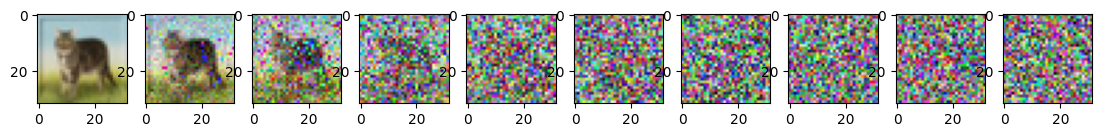

In [22]:
image = next(iter(trainloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(300/num_images)
for idx in range(0, 300, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = diffusion_model.forward(image, t, device=device)
    if len(img.shape) == 4:
        img = img[0, :, :, :] 
    plt.imshow(reverse_transform(img))

plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

---
Epoch: 0 | Train Loss 0.14438240254918736 | Val Loss 0.08637287324437729


<Figure size 1500x1500 with 0 Axes>

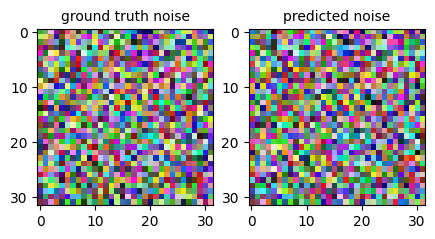

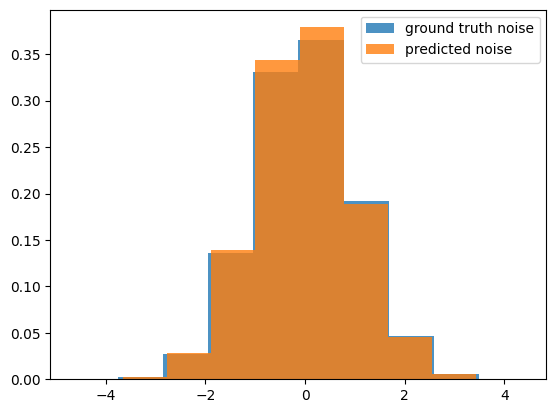

  4%|▍         | 2/50 [08:19<3:19:22, 249.22s/it]

---
Epoch: 1 | Train Loss 0.0802961864723609 | Val Loss 0.07453492804406545


  6%|▌         | 3/50 [12:23<3:13:30, 247.03s/it]

---
Epoch: 2 | Train Loss 0.07487931630741328 | Val Loss 0.07129401670625576


  8%|▊         | 4/50 [16:26<3:08:03, 245.29s/it]

---
Epoch: 3 | Train Loss 0.07220556276539962 | Val Loss 0.07108908958542041


 10%|█         | 5/50 [20:28<3:03:04, 244.11s/it]

---
Epoch: 4 | Train Loss 0.07079481886556516 | Val Loss 0.06899344209486093


 12%|█▏        | 6/50 [24:29<2:58:23, 243.25s/it]

---
Epoch: 5 | Train Loss 0.07060899515755666 | Val Loss 0.06929889674752186


 14%|█▍        | 7/50 [28:30<2:53:39, 242.31s/it]

---
Epoch: 6 | Train Loss 0.06906056645780037 | Val Loss 0.06729150797503117


 16%|█▌        | 8/50 [32:31<2:49:15, 241.81s/it]

---
Epoch: 7 | Train Loss 0.06817419217565121 | Val Loss 0.06890630191908433


 18%|█▊        | 9/50 [36:29<2:44:35, 240.87s/it]

---
Epoch: 8 | Train Loss 0.12464169499774774 | Val Loss 0.07912785010651135


 20%|██        | 10/50 [40:30<2:40:28, 240.71s/it]

---
Epoch: 9 | Train Loss 0.07621995299481428 | Val Loss 0.07215089733019853
---
Epoch: 10 | Train Loss 0.07278600639830797 | Val Loss 0.07074168023581688


<Figure size 1500x1500 with 0 Axes>

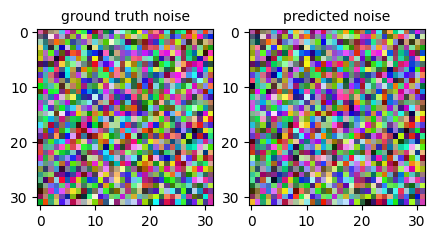

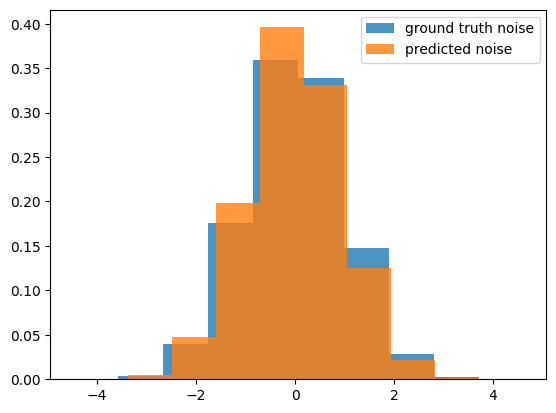

 24%|██▍       | 12/50 [48:33<2:32:43, 241.14s/it]

---
Epoch: 11 | Train Loss 0.07000333022994873 | Val Loss 0.06882302978864083


 26%|██▌       | 13/50 [52:33<2:28:28, 240.76s/it]

---
Epoch: 12 | Train Loss 0.06976898909570314 | Val Loss 0.06887250441389206


 28%|██▊       | 14/50 [56:33<2:24:17, 240.50s/it]

---
Epoch: 13 | Train Loss 0.06806104717155298 | Val Loss 0.0677567794919014


 30%|███       | 15/50 [1:00:33<2:20:13, 240.37s/it]

---
Epoch: 14 | Train Loss 0.06841394945214956 | Val Loss 0.06883953645443305


 32%|███▏      | 16/50 [1:04:33<2:16:08, 240.24s/it]

---
Epoch: 15 | Train Loss 0.0672112664542137 | Val Loss 0.068975741091447


 34%|███▍      | 17/50 [1:08:33<2:12:05, 240.16s/it]

---
Epoch: 16 | Train Loss 0.0673453625291586 | Val Loss 0.0685933749549664


 36%|███▌      | 18/50 [1:12:33<2:08:03, 240.11s/it]

---
Epoch: 17 | Train Loss 0.06676466043751973 | Val Loss 0.06675964875672108


 38%|███▊      | 19/50 [1:16:33<2:04:00, 240.01s/it]

---
Epoch: 18 | Train Loss 0.06746659462268535 | Val Loss 0.06736554234073712


 40%|████      | 20/50 [1:20:32<1:59:57, 239.91s/it]

---
Epoch: 19 | Train Loss 0.06671084467417154 | Val Loss 0.06710750834108928
---
Epoch: 20 | Train Loss 0.06726242298117051 | Val Loss 0.06740589774189851


<Figure size 1500x1500 with 0 Axes>

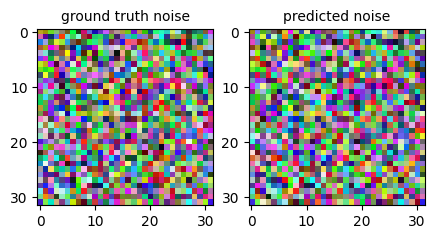

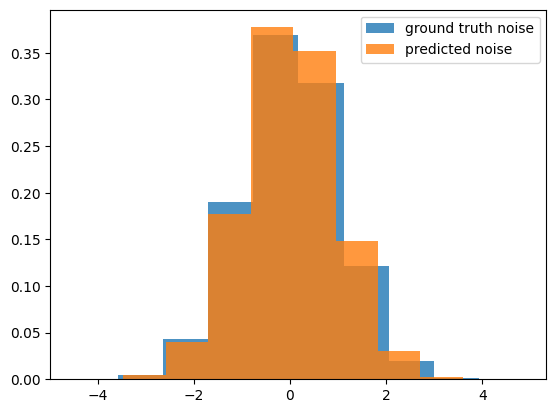

 44%|████▍     | 22/50 [1:28:33<1:52:01, 240.05s/it]

---
Epoch: 21 | Train Loss 0.06713273100172862 | Val Loss 0.06627562532249169


 46%|████▌     | 23/50 [1:32:32<1:47:55, 239.84s/it]

---
Epoch: 22 | Train Loss 0.06640662281559064 | Val Loss 0.06564176249771546


 48%|████▊     | 24/50 [1:36:32<1:43:53, 239.76s/it]

---
Epoch: 23 | Train Loss 0.06640178828667372 | Val Loss 0.06621862484667546


 50%|█████     | 25/50 [1:40:32<1:39:55, 239.80s/it]

---
Epoch: 24 | Train Loss 0.06686507883744362 | Val Loss 0.06582771991498959


 52%|█████▏    | 26/50 [1:44:31<1:35:54, 239.77s/it]

---
Epoch: 25 | Train Loss 0.0658041915927942 | Val Loss 0.06550028824653381


 54%|█████▍    | 27/50 [1:48:31<1:31:51, 239.61s/it]

---
Epoch: 26 | Train Loss 0.06594932741270615 | Val Loss 0.06545669552034293


 56%|█████▌    | 28/50 [1:52:30<1:27:49, 239.54s/it]

---
Epoch: 27 | Train Loss 0.06541986104387504 | Val Loss 0.06520384435470288


 58%|█████▊    | 29/50 [1:56:30<1:23:52, 239.62s/it]

---
Epoch: 28 | Train Loss 0.06587388526934844 | Val Loss 0.06579030319475211


 60%|██████    | 30/50 [2:00:29<1:19:52, 239.61s/it]

---
Epoch: 29 | Train Loss 0.06588983148909532 | Val Loss 0.06515603077908357
---
Epoch: 30 | Train Loss 0.06477672664973981 | Val Loss 0.06357116801425433


<Figure size 1500x1500 with 0 Axes>

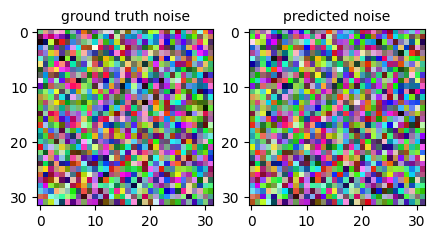

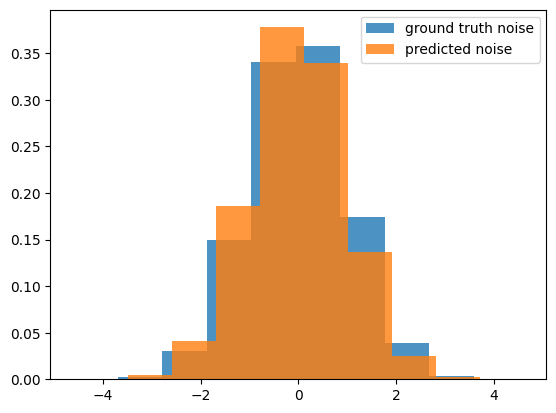

 64%|██████▍   | 32/50 [2:08:30<1:11:57, 239.86s/it]

---
Epoch: 31 | Train Loss 0.06550601500158126 | Val Loss 0.06450899265324458


 66%|██████▌   | 33/50 [2:12:29<1:07:56, 239.81s/it]

---
Epoch: 32 | Train Loss 0.06438703234188067 | Val Loss 0.06465745168045545


 68%|██████▊   | 34/50 [2:16:29<1:03:57, 239.84s/it]

---
Epoch: 33 | Train Loss 0.06472634613896028 | Val Loss 0.06615710798173378


 70%|███████   | 35/50 [2:20:29<59:57, 239.84s/it]  

---
Epoch: 34 | Train Loss 0.06588373142175186 | Val Loss 0.0653405096859504


 72%|███████▏  | 36/50 [2:24:29<55:56, 239.73s/it]

---
Epoch: 35 | Train Loss 0.06463081006629345 | Val Loss 0.06565491167398599


 74%|███████▍  | 37/50 [2:28:28<51:55, 239.67s/it]

---
Epoch: 36 | Train Loss 0.06602951494547037 | Val Loss 0.06559681443449779


 76%|███████▌  | 38/50 [2:32:28<47:54, 239.58s/it]

---
Epoch: 37 | Train Loss 0.0650495909440976 | Val Loss 0.06593535830959296


 78%|███████▊  | 39/50 [2:36:27<43:54, 239.52s/it]

---
Epoch: 38 | Train Loss 0.06476742355869367 | Val Loss 0.0641553015089952


 80%|████████  | 40/50 [2:40:27<39:55, 239.56s/it]

---
Epoch: 39 | Train Loss 0.06410948481315222 | Val Loss 0.06572649317483108
---
Epoch: 40 | Train Loss 0.06400934497897441 | Val Loss 0.06565804679233295


<Figure size 1500x1500 with 0 Axes>

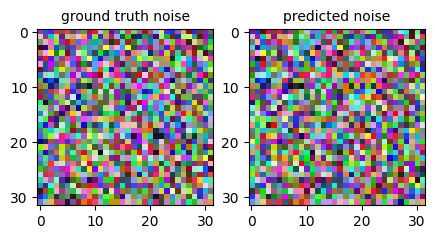

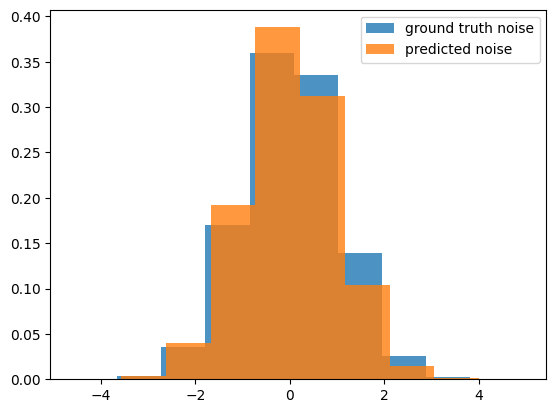

 84%|████████▍ | 42/50 [2:48:27<31:58, 239.86s/it]

---
Epoch: 41 | Train Loss 0.06466392929164264 | Val Loss 0.06341577493227445


 86%|████████▌ | 43/50 [2:52:26<27:57, 239.67s/it]

---
Epoch: 42 | Train Loss 0.06469731990916607 | Val Loss 0.06366597550610702


 88%|████████▊ | 44/50 [2:56:26<23:57, 239.62s/it]

---
Epoch: 43 | Train Loss 0.06424555141383256 | Val Loss 0.06619250163053855


 90%|█████████ | 45/50 [3:00:26<19:58, 239.68s/it]

---
Epoch: 44 | Train Loss 0.0645759112177751 | Val Loss 0.06560630303544876


 92%|█████████▏| 46/50 [3:04:25<15:58, 239.61s/it]

---
Epoch: 45 | Train Loss 0.06417353997627893 | Val Loss 0.06375909056992103


 94%|█████████▍| 47/50 [3:08:25<11:58, 239.64s/it]

---
Epoch: 46 | Train Loss 0.06474450037647517 | Val Loss 0.06432327905144447


 96%|█████████▌| 48/50 [3:12:24<07:59, 239.52s/it]

---
Epoch: 47 | Train Loss 0.06451728232204915 | Val Loss 0.0632817707478236


 98%|█████████▊| 49/50 [3:16:24<03:59, 239.58s/it]

---
Epoch: 48 | Train Loss 0.063490318831725 | Val Loss 0.06289816757616325


100%|██████████| 50/50 [3:20:23<00:00, 240.48s/it]

---
Epoch: 49 | Train Loss 0.0635043995693708 | Val Loss 0.06440546626272874


In [23]:
for epoch in tqdm.tqdm(range(NO_EPOCHS)):
#     torch.cuda.empty_cache()
    mean_epoch_loss = []
    mean_epoch_loss_val = []
#     trainloader_step = 1
#     testloader_step = 1
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss_with_regularization = loss + WEIGHT_DECAY * sum(p.pow(2.0).sum() for p in unet.parameters())
        loss_with_regularization.backward()
#         memory()
        optimizer.step()
#         print(f"loader step: {trainloader_step} on device {device}")
#         trainloader_step += 1

    for batch, label in testloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())
#         memory()
#         print(f"test loader step: {testloader_step} on device {device}")
#         testloader_step += 1

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        
        if epoch % SAVE_FREQUENCY == 0:
            if VERBOSE:
                with torch.no_grad():
                    plot_noise_prediction(noise[0], predicted_noise[0])
                    plot_noise_distribution(noise, predicted_noise)

            torch.save(unet.state_dict(), f"epoch: {epoch}")

In [26]:
unet_to_test = UNet(labels=True)
unet_to_test.load_state_dict(torch.load(("epoch: 40")))

<All keys matched successfully>

In [27]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [29]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 1500x1500 with 0 Axes>